# Part 1: Zero Noise Extrapolation with Qiskit: Find best extrapolation

In this part, we will use circuit folding and gate folding with various extrapolation to find the best suit of each folding. We will use Qiskit.

The criteria would be fidelity.

## I. Import Library

1. Import classical libraries

In [1]:
import sys
sys.path.append("Help Functions")

import numpy as np
import extrapolation
import matplotlib.pyplot as plt

2. Import quantum libraries

In [2]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, pauli_error
from qiskit.quantum_info import state_fidelity, DensityMatrix

## II. Help function for simulation

1. Create ideal GHZ circuit

In [3]:
def create_GHZ_circuit(num_qubits):
    qc = QuantumCircuit(num_qubits)
    qc.h(0)
    for i in range(num_qubits - 1):
        qc.cx(i, i + 1)
    return qc

2. Make Noise Model (only have in Qiskit)

In [4]:
def make_noise_model(p):
    noise_model = NoiseModel()

    error_1q = pauli_error([('X', p/3), ('Y', p/3), ('Z', p/3), ('I', 1 - p)])
    error_2q = error_1q.tensor(error_1q)

    noise_model.add_all_qubit_quantum_error(error_1q, ['h'])
    noise_model.add_all_qubit_quantum_error(error_2q, ['cx'])
    
    return noise_model

3. Set up Aer Simulators with given error probability

In [5]:
def set_up_simu(p):
    noise_model = make_noise_model(p)
    noise_simulator = AerSimulator(method='density_matrix', noise_model=noise_model)
    return noise_simulator

4. Create & compiled noisy GHZ circuit on Aer Simulators

In [6]:
def noisy_GHZ_circuit(num_qubits, simulator):
    ideal_GHZ_circuit = create_GHZ_circuit(num_qubits) 
    ideal_GHZ_circuit.save_density_matrix()
    compiled_circuit = transpile(ideal_GHZ_circuit, simulator, optimization_level=0)

    return compiled_circuit

5. Running noise GHZ simulation

In [7]:
def set_noise_exp(num_qubits, p):  
    noise_simulator = set_up_simu(p)
    compiled_noise_circuit = noisy_GHZ_circuit(num_qubits, noise_simulator)

    result = noise_simulator.run(compiled_noise_circuit).result()
    
    return compiled_noise_circuit, result

6. Fidelity between ideal GHZ circuit vs noise GHZ circuit

In [8]:
def fidelity_ideal_noise(ideal_circuit, noise_result):
    ideal_state = DensityMatrix.from_instruction(ideal_circuit)
    noisy_state = DensityMatrix(noise_result.data(0)['density_matrix'])

    return state_fidelity(ideal_state, noisy_state)

## III. Circuit folding and gate folding

1. Folding circuit

In [9]:
def folding_circuit(num_qubits, n): 
    qc = create_GHZ_circuit(num_qubits)
    for _ in range(n): 
        qc.h(0) 
        for i in range(num_qubits - 1): 
            qc.cx(i, i + 1) 
        for i in reversed(range(num_qubits - 1)): 
            qc.cx(i, i + 1) 
        qc.h(0) 
    return qc

def folding_circuit_exp(num_qubits, p, n):  
    noise_simulator = set_up_simu(p)
    
    folding_GHZ_circuit = folding_circuit(num_qubits, n)
    folding_GHZ_circuit.save_density_matrix()

    compiled_circuit = transpile(folding_GHZ_circuit, noise_simulator, optimization_level=0)

    result = noise_simulator.run(compiled_circuit).result()
    
    return compiled_circuit, result

2. Folding gate

In [10]:
def folding_gate(num_qubits, n):
    qc = QuantumCircuit(num_qubits)

    for _ in range(n):
        qc.h(0)
        qc.h(0)
    qc.h(0)  

    for i in range(num_qubits - 1):
        for _ in range(n):
            qc.cx(i, i + 1)
            qc.cx(i, i + 1)
        qc.cx(i, i + 1) 
    
    return qc

def folding_gate_exp(num_qubits, p, n):  
    noise_simulator = set_up_simu(p)
    
    folding_GHZ_circuit = folding_gate(num_qubits, n)
    folding_GHZ_circuit.save_density_matrix()

    compiled_circuit = transpile(folding_GHZ_circuit, noise_simulator, optimization_level=0)

    result = noise_simulator.run(compiled_circuit).result()
    
    return compiled_circuit, result

## IV. Run experiment

1. Set up

In [11]:
qubit_sizes = list(range(2, 11))
noise = 0.02

2. Execute

In [12]:
results_circuit = []
results_gate = []
execution_times = []
stretch = (1,3,5,7,9,11)

for num_qubits in qubit_sizes:
    print(f"\nRunning scalability test for {num_qubits} qubits...")

    ideal_ghz_circuit = create_GHZ_circuit(num_qubits)
    compiled_noise_circuit, noise_result= set_noise_exp(num_qubits, noise)
    
    fidelity_before_ZNE = fidelity_ideal_noise(ideal_ghz_circuit, noise_result)
    print(f"  Fidelity before ZNE: {fidelity_before_ZNE:.4f}")
    
    # Circuit folding experiment
    qubit_fidelities = []

    for i in range(0, 6):
        compiled_noise_circuit, noise_result= folding_circuit_exp(num_qubits, noise, i)
        fidelity = fidelity_ideal_noise(ideal_ghz_circuit, noise_result)
        qubit_fidelities.append(fidelity)

    zero_poly_fidelity = extrapolation.polynomial_extrapolation(stretch, qubit_fidelities) 
    zero_poly_deg3_fidelity = extrapolation.polynomial_extrapolation(stretch, qubit_fidelities, deg=3)
    zero_linear_fidelity = extrapolation.linear_extrapolation(stretch, qubit_fidelities) 
    zero_expo_fidelity = extrapolation.exponential_extrapolation(stretch, qubit_fidelities) 

    print("\n------------------------------------------Circuit Folding------------------------------------------")
    print(f"  Extrapolated zero-noise fidelity with Polynomial fidelity - quadratic: {zero_poly_fidelity:.4f}")
    print(f"  Extrapolated zero-noise fidelity with Polynomial fidelity - Degree 3: {zero_poly_deg3_fidelity:.4f}")
    print(f"  Extrapolated zero-noise fidelity with Linear fidelity: {zero_linear_fidelity:.4f}")
    print(f"  Extrapolated zero-noise fidelity with Exponential fidelity: {zero_expo_fidelity:.4f}")

    results_circuit.append((num_qubits, fidelity_before_ZNE, 
                            zero_poly_fidelity, zero_poly_deg3_fidelity, zero_linear_fidelity, zero_expo_fidelity))

    # Gate folding experiment
    qubit_fidelities = []

    for i in range(0, 6):
        compiled_noise_circuit, noise_result= folding_gate_exp(num_qubits, noise, i)
        fidelity = fidelity_ideal_noise(ideal_ghz_circuit, noise_result)
        qubit_fidelities.append(fidelity)

    zero_poly_fidelity = extrapolation.polynomial_extrapolation(stretch, qubit_fidelities) 
    zero_poly_deg3_fidelity = extrapolation.polynomial_extrapolation(stretch, qubit_fidelities, deg=3)
    zero_linear_fidelity = extrapolation.linear_extrapolation(stretch, qubit_fidelities) 
    zero_expo_fidelity = extrapolation.exponential_extrapolation(stretch, qubit_fidelities) 

    print("\n------------------------------------------Gate Folding------------------------------------------")
    print(f"  Extrapolated zero-noise fidelity with Polynomial fidelity - quadratic: {zero_poly_fidelity:.4f}")
    print(f"  Extrapolated zero-noise fidelity with Polynomial fidelity - Degree 3: {zero_poly_deg3_fidelity:.4f}")
    print(f"  Extrapolated zero-noise fidelity with Linear fidelity: {zero_linear_fidelity:.4f}")
    print(f"  Extrapolated zero-noise fidelity with Exponential fidelity: {zero_expo_fidelity:.4f}")

    results_gate.append((num_qubits, fidelity_before_ZNE, 
                         zero_poly_fidelity, zero_poly_deg3_fidelity, zero_linear_fidelity, zero_expo_fidelity))


Running scalability test for 2 qubits...
  Fidelity before ZNE: 0.9479

------------------------------------------Circuit Folding------------------------------------------
  Extrapolated zero-noise fidelity with Polynomial fidelity - quadratic: 1.0025
  Extrapolated zero-noise fidelity with Polynomial fidelity - Degree 3: 1.0065
  Extrapolated zero-noise fidelity with Linear fidelity: 0.9647
  Extrapolated zero-noise fidelity with Exponential fidelity: 0.9894

------------------------------------------Gate Folding------------------------------------------
  Extrapolated zero-noise fidelity with Polynomial fidelity - quadratic: 0.9908
  Extrapolated zero-noise fidelity with Polynomial fidelity - Degree 3: 0.9931
  Extrapolated zero-noise fidelity with Linear fidelity: 0.9652
  Extrapolated zero-noise fidelity with Exponential fidelity: 0.9811

Running scalability test for 3 qubits...
  Fidelity before ZNE: 0.9107

------------------------------------------Circuit Folding---------------

## VI. Plot scalability results

1. Graph comparing fidelity between different extrapolation methods using Circuit Folding

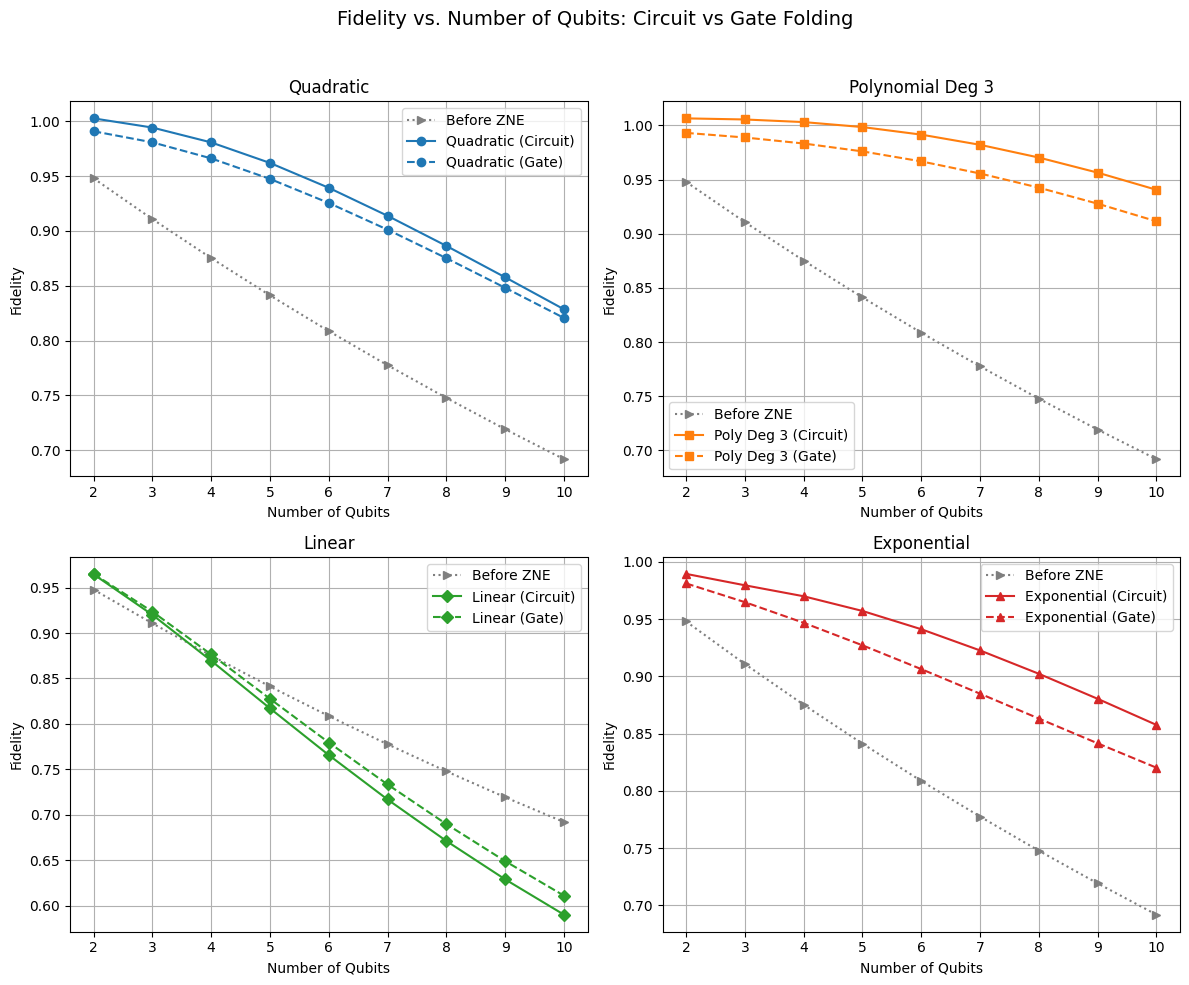

In [ ]:
num_qubits_circuit, fidelities_before, fidelities_poly_circ, fidelities_deg3_poly_circ, fidelities_linear_circ, fidelities_exp_circ = zip(*results_circuit)
num_qubits_gate, _, fidelities_poly_gate, fidelities_deg3_poly_gate, fidelities_linear_gate, fidelities_exp_gate = zip(*results_gate)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

markers = ['o', 's', 'D', '^', 'v']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
line_styles = ['-', '--']

axes[0,0].plot(num_qubits_circuit, fidelities_before, marker='>', color='tab:gray', linestyle=':', label="Before ZNE")
axes[0,0].plot(num_qubits_circuit, fidelities_poly_circ, marker=markers[0], color=colors[0], linestyle=line_styles[0], label="Quadratic (Circuit)")
axes[0,0].plot(num_qubits_gate, fidelities_poly_gate, marker=markers[0], color=colors[0], linestyle=line_styles[1], label="Quadratic (Gate)")
axes[0,0].set_title("Quadratic")
axes[0,0].set_xlabel("Number of Qubits")
axes[0,0].set_ylabel("Fidelity")
axes[0,0].grid(True)
axes[0,0].legend()

axes[0,1].plot(num_qubits_circuit, fidelities_before, marker='>', color='tab:gray', linestyle=':', label="Before ZNE")
axes[0,1].plot(num_qubits_circuit, fidelities_deg3_poly_circ, marker=markers[1], color=colors[1], linestyle=line_styles[0], label="Poly Deg 3 (Circuit)")
axes[0,1].plot(num_qubits_gate, fidelities_deg3_poly_gate, marker=markers[1], color=colors[1], linestyle=line_styles[1], label="Poly Deg 3 (Gate)")
axes[0,1].set_title("Polynomial Deg 3")
axes[0,1].set_xlabel("Number of Qubits")
axes[0,1].set_ylabel("Fidelity")
axes[0,1].grid(True)
axes[0,1].legend()

axes[1,0].plot(num_qubits_circuit, fidelities_before, marker='>', color='tab:gray', linestyle=':', label="Before ZNE")
axes[1,0].plot(num_qubits_circuit, fidelities_linear_circ, marker=markers[2], color=colors[2], linestyle=line_styles[0], label="Linear (Circuit)")
axes[1,0].plot(num_qubits_gate, fidelities_linear_gate, marker=markers[2], color=colors[2], linestyle=line_styles[1], label="Linear (Gate)")
axes[1,0].set_title("Linear")
axes[1,0].set_xlabel("Number of Qubits")
axes[1,0].set_ylabel("Fidelity")
axes[1,0].grid(True)
axes[1,0].legend()

axes[1,1].plot(num_qubits_circuit, fidelities_before, marker='>', color='tab:gray', linestyle=':', label="Before ZNE")
axes[1,1].plot(num_qubits_circuit, fidelities_exp_circ, marker=markers[3], color=colors[3], linestyle=line_styles[0], label="Exponential (Circuit)")
axes[1,1].plot(num_qubits_gate, fidelities_exp_gate, marker=markers[3], color=colors[3], linestyle=line_styles[1], label="Exponential (Gate)")
axes[1,1].set_title("Exponential")
axes[1,1].set_xlabel("Number of Qubits")
axes[1,1].set_ylabel("Fidelity")
axes[1,1].grid(True)
axes[1,1].legend()

plt.suptitle("Fidelity vs. Number of Qubits: Circuit vs Gate Folding", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()